In [614]:
DEBATE_URL = 'http://www.presidency.ucsb.edu/debates.php'
Q_DENSITY_CUTOFF = .0014
last_fetched_at = None
import json
import matplotlib.pyplot as plt
import urllib.request, time, re, random, hashlib
import bs4
import time
import sys
import nltk
import nltk.data
from itertools import combinations
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk import bigrams
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np
from scipy.spatial import distance
import time
import copy
PARTY_FILE = 'party_names.csv'
%matplotlib inline

In [615]:
def fetch(url):
    """Load the url compassionately."""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache/cache-file-{}'.format(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                #print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    #print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
    
        return result

In [616]:
def debate_processing(soup):
    return_list = []
    tables = soup.find_all('table')
    
    for table in tables:
        if table['width'] == '700' and table['bgcolor'] == "#FFFFFF":
            actual_table = table
    rows = actual_table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        
        cols = [x.text.strip() for x in cols]
        try:
            link = row.find('a')['href']
            cols.append(link)
            return_list.append(cols)
        except:
            pass

    return return_list

In [617]:
def get_words_from_speech(link):
    result = fetch(link)
    soup = bs4.BeautifulSoup(result,'lxml')
    return soup

In [618]:
def get_debate_dict():
    result = fetch(DEBATE_URL)
    soup = bs4.BeautifulSoup(result,'lxml')
    debate_list = debate_processing(soup)
    debate_dict = {}
    for debate in debate_list:

        if ' ' not in debate[0]:
            debate = debate[1:]
        debate_id = ' '.join(debate[:2])
        try:
            clean_time = debate[0].replace('th,',',').replace('st,',',').replace('rd,',',').replace('nd,',',')
            debate_datetime = time.strptime(clean_time,'%B %d, %Y')
            
        except:
            debate_datetime = None
            print(debate,'*********')

        debate_dict[debate_id] = {}
        debate_dict[debate_id]['link'] = debate[2]
        debate_dict[debate_id]['time'] = debate_datetime 
        
        try:
            debate_dict[debate_id]['soup'] = get_words_from_speech(debate[2])
        except:
            debate_dict[debate_id]['soup'] = None
        
    return debate_dict

In [265]:
def find_politician_names(debate_dict):
    for key in debate_dict.keys():
        raw = get_soup_text(debate_dict[key])
        raw = raw.replace("--", ". ")
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())

        #find candidate names, most commonly repeated first words of sentences, not common words
        colon_names = []
        period_names = []

        #get names from before colons
        for sent in sents:
            if ':' in sent:
                sent = sent.split(':')
                possible_name = sent[0] + ":"
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    colon_names.append(possible_name_no_paren)

        fdist1 = FreqDist(colon_names)
        fdist1_above_5 = [name[0] for name in fdist1.most_common(15) if name[1]>5]
        
        #get names before periods
        for sent in sents:
            if len(nltk.word_tokenize(sent))<5:
                possible_name = sent
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    period_names.append(possible_name_no_paren)
                    
        fdist2 = FreqDist(period_names)
        fdist2_above_15 = [name[0] for name in fdist2.most_common(15) if name[1]>15]
    
        #add names to dict
        colon_name_highest_freq = fdist1.most_common(1)[0][1]
        if colon_name_highest_freq > 20 :
            debate_dict[key]['names'] = fdist1_above_5
        else:
            debate_dict[key]['names'] = fdist2_above_15
            
    return debate_dict

In [266]:
def get_soup_text(dbt):
    raw = dbt['soup'].get_text()
    raw = raw.replace("\\", "")
    raw = raw.replace(".", ". ")
    raw = raw.replace("?", "? ")
    raw = raw.replace("!", "! ")
    raw = raw.replace("  ", " ")
    raw = raw.replace("-", "- ")
    raw = raw.replace("…", ". ")
    raw = raw.replace("...", ". ")
    return raw
    

In [267]:
def remove_paren(name):
    return_name = ''
    skip1c = 0
    skip2c = 0
    for i in name:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            return_name += i
    return return_name

In [268]:
def remove_non_politicians(cand_text_dict):
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            cand_text_dict[year][cand]['q_density'] = 0
            text = cand_text_dict[year][cand]['full_text']
            num_chars = len(list(text))
            num_q_marks = text.count('?')
            if num_chars > 0:
                cand_text_dict[year][cand]['q_density'] = num_q_marks/num_chars

    cand_text_dict_no_mod = copy.deepcopy(cand_text_dict)
    #remove liekly moderators
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            if ((cand == 'MALE' and 'MALE' in cand_text_dict_no_mod[year]) or 
                (cand == 'UNKNOWN' and 'UNKNOWN' in cand_text_dict_no_mod[year]) or 
                (cand == 'WRITE' and 'WRITE' in cand_text_dict_no_mod[year])):
                del cand_text_dict_no_mod[year][cand]
    
            if (cand_text_dict[year][cand]['q_density'] > Q_DENSITY_CUTOFF):
                if (cand in cand_text_dict_no_mod[year]):
                    del cand_text_dict_no_mod[year][cand]

        
    return cand_text_dict_no_mod

In [269]:
 def clean_dirty_name_lookup(names):
    
    lookup_dict = {}
    
    for name in names:
        clean_name = name.split()[-1].upper().replace('.','').replace(')','').replace(';','').replace(':','')
        lookup_dict[name] = clean_name
    
    return lookup_dict

In [270]:
def get_election_year(year, dbt):
    year = dbt['time'].tm_year
    year_mod = year % 4
    if year_mod == 0:
        election_year = year
    else:
        election_year = year + (4 - year_mod)
    return election_year

In [283]:
def clean_names(debate_dict):
    # Add debate year
    name_years = {}
    for dbt in debate_dict.keys():
        time = debate_dict[dbt]['time']

        # Get election year
        if time:
            election_year = get_election_year(time.tm_year, debate_dict[dbt])
        else:
            election_year = 'dbt'
        debate_dict[dbt]['election_year'] = election_year

        # Add new set of names from debate to name_years dict
        if election_year not in name_years:
            name_years[election_year] = {'names':set()}

        names = set(debate_dict[dbt]["names"])
        name_years[election_year]['names'] = name_years[election_year]['names'].union(names)

    # Reduce all names in one year to a single name
    for year in name_years:
        name_years[year]['lookup'] = clean_dirty_name_lookup(name_years[year]['names'])

    # Add lookup dictionary to debate dictionary
    for dbt in debate_dict.keys():
        election_year = debate_dict[dbt]['election_year']
        debate_dict[dbt]['lookup'] = name_years[election_year]['lookup']
        debate_dict[dbt]['clean_names'] = debate_dict[dbt]['lookup'].values()
    
    return debate_dict

In [613]:
def attribute_text(debate_dict):
    #make year/candidate dictionary for text
    cand_text_dict = {}
    for dbt in debate_dict.keys():
        year = debate_dict[dbt]['election_year']
        cand_text_dict[year] = {}
        for cand in debate_dict[dbt]["clean_names"]:
            cand_text_dict[year][cand] = {}
            cand_text_dict[year][cand]['full_text'] = ""
    
    #fill year/candidate dictionary
    for dbt in debate_dict.keys():
        #set variables
        year = debate_dict[dbt]["election_year"]
        names = debate_dict[dbt]["names"]
        if "write" in names:
            names.remove('write')
        
        #get debate soup
        raw = get_soup_text(debate_dict[dbt])
        
        #tokenize sents
        for name in names:
            raw = raw.replace(name, ". " + name)
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())
        
        #loop through sents
        current_speaker = ""
        got_first_speaker = False
        for sent in sents:
            new_speaker = (len([name for name in names if name in sent])>0)
            if(new_speaker):
                got_first_speaker = True
                current_speaker_dirty = [name for name in names if name in sent][0]
                current_speaker = debate_dict[dbt]["lookup"][current_speaker_dirty]
            
            if(got_first_speaker):
                sent_no_name = sent.replace(current_speaker_dirty, "")
                cand_text_dict[year][current_speaker]['full_text'] = (cand_text_dict[year][current_speaker]['full_text'] + " " + sent_no_name)
    
    #fix "president" as candidate name
    for year in cand_text_dict.keys():
        #loop through candidates
        if year == 2012:
            cand_text_dict[year]['OBAMA'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1996:
            cand_text_dict[year]['CLINTON'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1984:
            cand_text_dict[year]['REAGAN'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1980:
            cand_text_dict[year]['CARTER'] = cand_text_dict[year].pop('PRESIDENT')
        if year == 1976:
            cand_text_dict[year]['FORD'] = cand_text_dict[year].pop('PRESIDENT')
    return cand_text_dict

In [583]:
def similarity_model(cand_text_dict):
    dumbWords = stopwords.words('english')
    political_positions = ['Governor', 'Senator', 'President']
    
    
    #loop through election years
    for year in cand_text_dict.keys():
        #loop through candidates
        for cand in cand_text_dict[year].keys():
            #print(year, cand)
        
            tokens = nltk.word_tokenize(cand_text_dict[year][cand]['full_text'])
            text = nltk.Text(tokens)
            fdist_tokens = FreqDist(tokens)
            
            special_words = [word for word in tokens if len(word)>4 and fdist_tokens[word]>=5 
                             and wordnet.synsets(word) and word not in political_positions]
            cand_text_dict[year][cand]["special_words"] = special_words
            
            special_words_no_caps = [word for word in tokens if len(word)>4 and fdist_tokens[word]>=5 
                             and wordnet.synsets(word) and word[0].islower()]
            cand_text_dict[year][cand]["special_words_no_caps"] = special_words_no_caps
            
            if len(text)>0:
                #avg word len
                sum_len = sum([len(word) for word in text])
                cand_text_dict[year][cand]["avg_word_len"] = sum_len/len(text)
                
                #avg word len, no stopwords
                text_no_dumbWords = [word for word in text if word not in dumbWords]
                sum_len = sum([len(word) for word in text_no_dumbWords])
                cand_text_dict[year][cand]["avg_word_len_no_stopword"] = sum_len/len(text_no_dumbWords)
                
                #lex diversity                
                cand_text_dict[year][cand]["lex_diversity"] = (len(set(text)) / len(text))

                
                #lex diversity  no stopwords              
                cand_text_dict[year][cand]["lex_diversity_no_stopword"] = (len(set(text_no_dumbWords)) / len(text_no_dumbWords))
            
 
            bgrms = list(bigrams(text))
            cand_text_dict[year][cand]["bgrms"] = bgrms
            
            fdist_bgrms = FreqDist(bgrms)
            special_bgrms = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1])]
            cand_text_dict[year][cand]["special_bgrms"] = special_bgrms
            
            special_bgrms_no_caps = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1]) 
                                     and bgm[0][0].islower() and bgm[1][0].islower()]
            cand_text_dict[year][cand]["special_bgrms_no_caps"] = special_bgrms_no_caps
            
            special_bgrms_no_caps_stopwords = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1]) 
                                     and bgm[0][0].islower() and bgm[1][0].islower()
                                              and bgm[0] not in dumbWords and bgm[1] not in dumbWords]
            cand_text_dict[year][cand]["special_bgrms_no_caps_stopwords"] = special_bgrms_no_caps_stopwords
            

            cand_text_dict[year][cand]["compound_bgms"] = ''
            for bgm in cand_text_dict[year][cand]["bgrms"]:
                compound_bgm = bgm[0] + '_' + bgm[1]
                cand_text_dict[year][cand]["compound_bgms"] += (compound_bgm + ' ')

                    
            
    return cand_text_dict
        

In [582]:
def build_text_dict():
    debate_dict = get_debate_dict()

    #find the names of the participants
    debate_dict = find_politician_names(debate_dict)
    
    #clean names and years for comparison within electoral years
    debate_dict = clean_names(debate_dict)

    #compile all text by candidate-year
    cand_text_dict = attribute_text(debate_dict)

    #create a model of text similarity
    cand_text_dict = similarity_model(cand_text_dict)
    
    cand_text_dict = remove_non_politicians(cand_text_dict)

    return cand_text_dict





In [508]:
def build_score_and_data_matrix(debate_dict,var_list,distance_method,weights=None):
    
    # locations of id and text in score dataframe
    cand_scores = []
    for year in debate_dict:
        # Build each row of dataframe
        for candidate in debate_dict[year]:
            cand_year_dict = debate_dict[year][candidate]
            cand_id = candidate + '_' + str(year)
            var_score_list = [cand_year_dict[x] for x in cand_year_dict if x in var_list]
            cand_scores.append([cand_id,cand_year_dict['full_text']] + var_score_list)
            
    # build normalized dataframe with name and text as first columns, var_list as col keys
    cand_df = normalize_scores(cand_scores,var_list)   

    # build tfidf Matrix and add to original matrix
    tfidf_freq = get_tfidf_vectors(cand_df['full_text'])
    tf_cols = list(tfidf_freq.columns)
    df = pd.concat([cand_df,tfidf_freq],axis=1)

    
    num_rows = len(df)
    dist_dict = {}
    # Loop over all combinations and calculate distances
    for i in range(num_rows-1):
        if i % 10 == 0:
            print(i)
        for j in range(i+1,num_rows):
            
            # default to equal weights
            if weights == None:
                weights = [1]*(len(var_list) + 1)
            
            name1 = df.ix[i]['cand_name']
            name2 = df.ix[j]['cand_name']
            score = calculate_score(df.ix[i],df.ix[j],weights,var_list,tf_cols,distance_method)
            

            # fill both sides of dictionary with relative distances

            if name1 not in dist_dict:
                dist_dict[name1] = {}
            if name2 not in dist_dict:
                dist_dict[name2] = {}
            dist_dict[name1][name2] = score
            dist_dict[name2][name1] = score


    return df,dist_dict        

def calculate_score(row1,row2,weights,var_list,tfidf_cols,distance_method):

    # calculate weighted rows and find distance between with given method
    tfidf_weight = weights['tfidf']
    var_weights = weights['var']
    
    
    # equal weight to all tfidf features
    tfidf_score = distance_method(row1[tfidf_cols],row2[tfidf_cols])
    tfidf_weighted = tfidf_score * tfidf_weight
    
    var_scores = []
    for i, var in enumerate(var_list):
        d = (row1[var] - row2[var])**2 # Take square of difference as distance
        var_scores.append(d * var_weights[i])

    return tfidf_weighted + sum(var_scores) # return sum of weighted scores

def weight_rows(row,col_list,weight_list):
    rv = np.array(row[col_list[0]]) * weight_list[0]
    for i in range(1,len(col_list)):
        rv = np.hstack([rv,np.array(row[col_list[i]]*weight_list[i])])
    
    return rv

def normalize_scores(list_of_scores,var_list):
    
    df = pd.DataFrame(list_of_scores)
    
    # Rename columns
    col_dict = {0:'cand_name',1:'full_text'}
    for i, var in enumerate(var_list):
        col_dict[i+2] = var
    df = df.rename(columns=col_dict)
    df.fillna(0,inplace=True) # non-existent should be 0
    
    
    df[var_list] = normalize(df[var_list],'l1',axis=0)
    return df

def get_tfidf_vectors(list_of_texts):
    # Used basis of code from hw 1
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = stopwords.words('english'),
                                 lowercase= True,
                                 max_features = 1000,
                                 smooth_idf = True) # Enable smoothing
    compressed_vectors = vectorizer.fit_transform(list_of_texts)
    df = pd.DataFrame(compressed_vectors.toarray())
    df.columns = vectorizer.get_feature_names()
    return df 

In [600]:
def build_distance_matrix(raw_scores,dist_dict):
    names = list(raw_scores['cand_name'])
    score_compare = pd.DataFrame(index=names,columns=names)
    
    # fill rows with mutuals scores for each candidate
    for name in names:
        new_col = []
        for compare_name in names:
            try:
                new_col.append(dist_dict[name][compare_name])
            except:
                new_col.append(np.nan)
        score_compare[name] = new_col
    score_compare.fillna(np.nan,inplace=True)
    
    rv = score_compare.merge(raw_scores,left_index=True,right_on='cand_name')
    rv['year_num'] = rv['cand_name'].apply(lambda x: x.split('_')[1])
    
    return rv.set_index('cand_name')

def add_clusters(df,added_fields,num_clusters):
    # cluster only on data on speeches
    kmeans = KMeans(n_clusters=num_clusters)    
    kmeans.fit_predict(df.drop(added_fields,axis=1))
    df['clusters'] = kmeans.labels_
    return df
    
    

In [601]:
def join_parties(df):
    parties = pd.read_csv(PARTY_FILE,index_col='id')
    joined_df = df.join(parties)
    joined_df = joined_df[joined_df['party_name'] != 0]
    return joined_df
    

In [599]:
def build_plots(raw_scores,name,dist_dict):
    for num_clusters in range(2,8):
        #clusters need to be built on raw data
        cluster_df = add_clusters(raw_scores,added_fields,num_clusters)
        # Calculate and add scores
        score_df = build_distance_matrix(cluster_df,dist_dict)
        joined_df = join_parties(score_df)       
        year = [float(x) + np.random.random()*2 for x in joined_df['year_num']]
        party = [float(x) + np.random.random()*.2 for x in joined_df['party_name']]
        joined_df.drop('full_text',axis=1,inplace=True)
        joined_df.to_csv('clusters/' + name + '_' + 'clusters_' + str(num_clusters)+ '.csv')
        plt.scatter(year,party,c=joined_df['clusters'],cmap='Spectral')
        plt.title(str(num_clusters) + ' Clusters')
        plt.xlabel('Year')
        plt.ylabel('Party: 1=Dem, 2=Rep, 3=Other')
        plt.savefig('clusters/' + name + '_' + str(num_clusters) + '_Clusters.png')
        plt.show()
        

In [541]:
cand_text_dict = build_text_dict()
raw_scores,dist_dict = build_score_and_data_matrix(cand_text_dict,var_names,cosine,weights)

In [578]:
cand_text_dict[1984]['BUSH'].keys()

dict_keys(['special_bgrms_no_caps', 'special_words', 'bgrms', 'lex_diversity_no_stopword', 'avg_word_len_no_stopword', 'full_text', 'avg_word_len', 'compound_bgms', 'special_bgrms_no_caps_stopwords', 'lex_diversity', 'q_density', 'special_words_no_caps', 'special_bgrms'])

In [584]:
cand_text_dict = build_text_dict()

In [592]:
added_fields = ['cand_name','full_text'] #fields added in building matrix
var_names = ['avg_word_len','avg_word_len_no_stopword', 'lex_diversity_no_stopword']
weights = {'var':[1,1,1],'tfidf':4,'tfidf_bigrams':4}
num_clusters = 8
raw_scores,dist_dict = build_score_and_data_matrix(cand_text_dict,var_names,cosine,weights)
distance_matrix = build_distance_matrix(cluster_df,dist_dict)



0
10
20
30
40
50
60
70
80
90
100


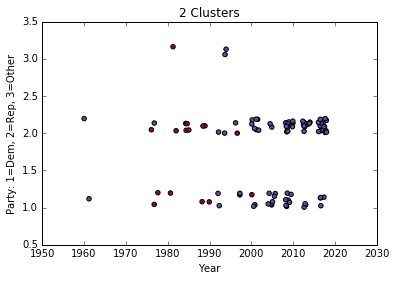

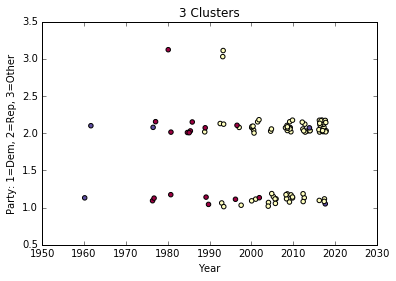

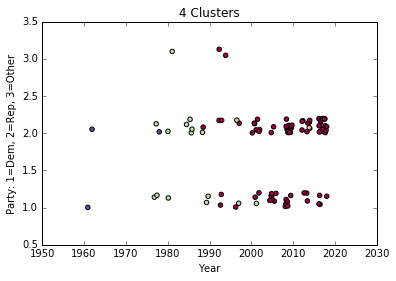

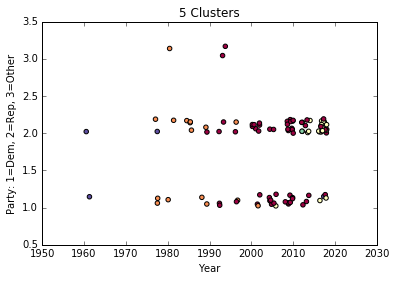

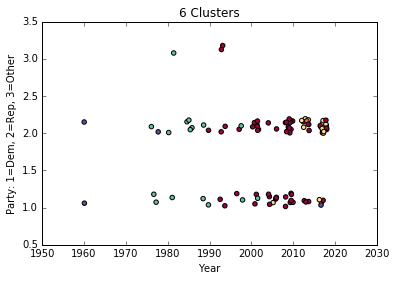

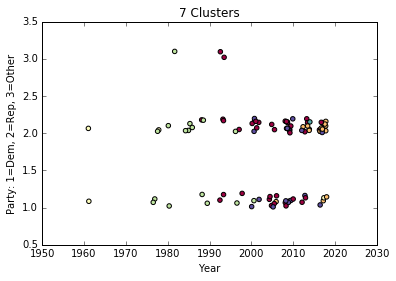

In [586]:
build_plots(raw_scores,'even',dist_dict)

In [589]:
def output_pairs(name,year):
    name_id = name.upper() + '_' + str(year)
    score_df = build_distance_matrix(raw_scores,dist_dict)
    score_df = join_parties(score_df)
    print("Top 10 Pairs")
    print(score_df[name_id].sort_values()[:10])
    print()
    print("Lowest 10 Pairs")
    print(score_df[name_id].sort_values()[-11:])
    print()

In [585]:
def cand_info(name,year):
    cand_dict = cand_text_dict[year][name]
    print("Average Word Length",cand_dict['avg_word_len'])
    print("w/o stopwords",cand_dict['avg_word_len_no_stopword'])
    print()
    print("Lexical Diversity")
    print(cand_dict['lex_diversity_no_stopword'])
    print("Top 10 bigrams")
    top_10 = FreqDist(cand_dict['special_bgrms_no_caps_stopwords']).most_common(10)
    for item in top_10:
        print(item[0][0] + ' ' + item[0][1] + ': ', str(item[1]))


In [612]:
name1 = input('Candidate Name 1').upper()
year1 = int(input('Candidate Year 1'))

name2 = input('Candidate Name 2').upper()
year2 = int(input('Candidate Year 2'))

id_1 = name1 + '_' + str(year1)
id_2 = name2 + '_' + str(year2)

print()
print("Distance: ",distance_matrix[id_1][id_2],'\n')
print(id_1, '\n')
print(cand_info(name1,year1))
print('\n',id_2,'\n')
print(cand_info(name2,year2))

Candidate Name 1clinton
Candidate Year 11992
Candidate Name 2clinton
Candidate Year 22016

Distance:  1.17224238463 

CLINTON_1992 

Average Word Length 3.8773194723898947
w/o stopwords 4.482949392345366

Lexical Diversity
0.20886994376927262
Top 10 bigrams
health care:  37
middle class:  20
care costs:  16
private sector:  9
family values:  8
control health:  8
even though:  7
class tax:  7
job growth:  7
years ago:  7
None

 CLINTON_2016 

Average Word Length 3.8344431356522994
w/o stopwords 4.432336584186347

Lexical Diversity
0.14064640928508101
Top 10 bigrams
health care:  34
make sure:  24
young people:  17
middle class:  14
law enforcement:  11
health insurance:  10
criminal justice:  10
put together:  10
immigration reform:  9
insurance companies:  9
None


In [590]:
name = 'TRUMP'#input('Candidate Name').upper()
year = 2016#int(input('Candidate Year'))
output_pairs(name,year)
cand_info(name,year)



Top 10 Pairs
cand_name
HUCKABEE_2016    0.731384
KASICH_2016      0.755631
ROMNEY_2008      0.797856
HUCKABEE_2008    0.814019
CARSON_2016      0.850854
ROMNEY_2012      0.876523
SANTORUM_2016    0.877469
THOMPSON_2008    0.916868
PAUL_2012        0.943555
CLINTON_2016     0.985459
Name: TRUMP_2016, dtype: float64

Lowest 10 Pairs
cand_name
CHAFEE_2016       2.175036
PRESIDENT_1976    2.219815
MONDALE_1976      2.224566
NIXON_1960        2.228441
GORE_1996         2.384607
DOLE_1976         2.400952
KENNEDY_1960      2.452790
KEMP_1996         2.461560
PRESIDENT_1980    2.523677
GOV_2012          3.947944
TRUMP_2016             NaN
Name: TRUMP_2016, dtype: float64

Average Word Length 3.4043715846994536
w/o stopwords 3.6621227390866173

Lexical Diversity
0.11488887710178751
Top 10 bigrams
eminent domain:  18
get along:  15
take care:  15
many people:  14
come back:  12
jobs back:  11
years ago:  11
win anymore:  10
bring jobs:  10
one thing:  8
